# Time Analysis

In this notebook an analysis of time duration of each step in the inference process of the model is performed. In more detail, between two succesive frames there are two main computation stages:

1. Calculation of the action through neural network's forward pass
2. Rendering the next frames after feeding the environment with the calculated action

We desire to accelerate the forward pass of the model in order to achieve more frames per second.

In [1]:
import sys
sys.path.append('../src')
sys.path.append('../../learning/src')

import time, torch, logging, joblib
from torchvision import transforms as T
from torch.nn import functional as F 
from gym_duckietown.simulator import Simulator
from big_experiment_utils.wrappers import DiscreteWrapper, DtRewardWrapper
from collections import deque

from utilities import Timer

logger = logging.getLogger('gym-duckietown')
logger.setLevel(logging.WARNING)

DEBUG:commons:version: 6.2.4 *
DEBUG:typing:version: 6.2.3
DEBUG:duckietown_world:duckietown-world version 6.2.38 path /home/kanagnostopoulos/anaconda3/envs/rl/lib/python3.8/site-packages
DEBUG:geometry:PyGeometry-z6 version 2.1.4 path /home/kanagnostopoulos/anaconda3/envs/rl/lib/python3.8/site-packages
DEBUG:aido_schemas:aido-protocols version 6.0.59 path /home/kanagnostopoulos/anaconda3/envs/rl/lib/python3.8/site-packages
DEBUG:nodes:version 6.2.13 path /home/kanagnostopoulos/anaconda3/envs/rl/lib/python3.8/site-packages pyparsing 3.0.6
DEBUG:gym-duckietown:gym-duckietown version 6.1.31 path /home/kanagnostopoulos/Desktop/ReinforcementLearning/gym-duckietown/src



{'audio': ('xaudio2', 'directsound', 'openal', 'pulse', 'silent'), 'debug_font': False, 'debug_gl': True, 'debug_gl_trace': False, 'debug_gl_trace_args': False, 'debug_graphics_batch': False, 'debug_lib': False, 'debug_media': False, 'debug_texture': False, 'debug_trace': False, 'debug_trace_args': False, 'debug_trace_depth': 1, 'debug_trace_flush': True, 'debug_win32': False, 'debug_x11': False, 'graphics_vbo': True, 'shadow_window': True, 'vsync': None, 'xsync': True, 'xlib_fullscreen_override_redirect': False, 'darwin_cocoa': True, 'search_local_libs': True, 'headless': False, 'headless_device': 0}


Initially, we create the desired environment for testing and we apply that necessary wrappers to transform the action space of the environment.

Furthermore, it is necessary to isolator the actor as it is the only part of the model necessary for deciding the actions at inference time.

In [2]:
env = Simulator(
    seed=None,  # random seed
    map_name="loop_empty",
    max_steps=3_500,  
    domain_rand=False,
    distortion=False,
    camera_width=80,
    camera_height=60,
    draw_curve=True,
    accept_start_angle_deg=4
)
env = DtRewardWrapper(env)
env = DiscreteWrapper(env)

timer1 = Timer()
timer2 = Timer()
timer3 = Timer()
timer4 = Timer()

model = joblib.load('../models/duckieTown_PPO_simple.joblib')


class Actor(torch.nn.Module):
    #Implements the inference of only the actor model coming from the acotr critic object

    def __init__(self, 
                actor_critic_model,
                device = 'cpu'):
        #Initilizes actor by copying necesseary layers
        super(Actor, self).__init__()
        self.device = device
        self.conv_core = actor_critic_model.conv_core.to(device)
        self.actor_head = actor_critic_model.actor_head.to(device)
        self.transform = actor_critic_model.transform

    def forward(self, x):
        #Implements forward pass of model
        x = torch.permute(x, (0, 3, 1, 2))  # Place channel axis in correct position
        x = self.transform(x)               # Apply transform
        x = T.functional.crop(x, top=20, left=0, height=40, width=80)
        x = x.to(device=self.device)
        visual_repr = self.conv_core(x).squeeze(-1).squeeze(-1)  
        dist = F.log_softmax(self.actor_head(visual_repr), dim=1).to('cpu')
        dist = torch.distributions.Categorical(logits=dist)
        return dist.sample().cpu().numpy()[0]

model = Actor(model)

INFO:duckietown_world: data: /home/kanagnostopoulos/anaconda3/envs/rl/lib/python3.8/site-packages/duckietown_world/data


## Inference loop

In [3]:
frame = env.reset()
stacked_frames = deque([torch.zeros(size=frame.shape).unsqueeze(0)]*5,
                        maxlen=5)
env.render()
done = False
total_reward = 0
total_frames = 0
while not done:
    timer4.start()
    frame = torch.FloatTensor(frame).unsqueeze(0)
    stacked_frames.append(frame)
    state = torch.cat(tuple(stacked_frames), dim=-1)
    
    timer1.start()
    action = model.forward(state)
    timer1.stop()

    timer2.start()
    next_frame, reward, done, _ = env.step(action)
    timer2.stop()

    timer3.start()
    env.render()
    timer3.stop()
    
    frame = next_frame
    total_reward += reward
    total_frames += 1
    timer4.stop()
env.close()

print(f'Neural network average forward pass duration: {timer1.get_average_time():.5f}s')
print(f'Environment step method average duration: {timer2.get_average_time():.5f}s')
print(f'Environment rendering average duration: {timer3.get_average_time():.5f}s')
print(f'Total average per frame: {timer4.get_average_time():.5f}')
print(f'Frames per second (FPS): {1/timer4.get_average_time()}')
print(f'Number of frames in test: {timer4.get_laps()}')

Neural network average forward pass duration: 0.00194s
Environment step method average duration: 0.01339s
Environment rendering average duration: 0.01833s
Total average per frame: 0.03391
Frames per second (FPS): 29.48729447176661
Number of frames in test: 1977


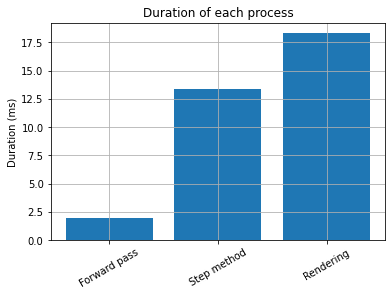

In [7]:
import matplotlib.pyplot as plt

plt.figure()
plt.bar(x=[1,2,3], height=[timer1.get_average_time()*1000, timer2.get_average_time()*1000, timer3.get_average_time()*1000])
plt.ylabel('Duration (ms)')
plt.xticks([1,2,3], ['Forward pass', 'Step method', 'Rendering'], rotation=30)
plt.title('Duration of each process')
plt.grid()
plt.savefig('../results/time_barplot', dpi=500)
plt.show()

As last step, we save the actor model to .pt form for later use.

In [5]:
torch.save(model, '../models/actor.pt')